# PARAMETROS

In [3]:
import ctypes
import tempfile
import subprocess
import os

c_code = r"""
#include <immintrin.h>

int rdseed32(unsigned int *out) {
    int ok;
    for (int i = 0; i < 10; ++i) {
        ok = _rdseed32_step(out);
        if (ok) return 1;
    }
    return 0;
}

int rdseed64(unsigned long long *out) {
    int ok;
    for (int i = 0; i < 10; ++i) {
        ok = _rdseed64_step(out);
        if (ok) return 1;
    }
    return 0;
}
"""

def compile_rdseed_lib():
    with tempfile.NamedTemporaryFile(suffix=".c", delete=False) as f:
        f.write(c_code.encode())
        c_path = f.name

    so_path = c_path.replace(".c", ".so")
    compile_cmd = [
        "gcc", "-shared", "-fPIC", "-O2", "-mrdseed", "-o", so_path, c_path
    ]

    subprocess.check_call(compile_cmd)
    os.remove(c_path)
    return ctypes.CDLL(so_path)

# Cargar lib y configurar argumentos
_rdseed = compile_rdseed_lib()
_rdseed.rdseed32.argtypes = [ctypes.POINTER(ctypes.c_uint)]
_rdseed.rdseed32.restype = ctypes.c_int

_rdseed.rdseed64.argtypes = [ctypes.POINTER(ctypes.c_ulonglong)]
_rdseed.rdseed64.restype = ctypes.c_int

# Funciones públicas
def seed32():
    out = ctypes.c_uint()
    if _rdseed.rdseed32(ctypes.byref(out)) == 0:
        raise RuntimeError("RDSEED32 falló después de varios intentos.")
    return out.value

def seed64():
    out = ctypes.c_ulonglong()
    if _rdseed.rdseed64(ctypes.byref(out)) == 0:
        raise RuntimeError("RDSEED64 falló después de varios intentos.")
    return out.value


In [1048]:
from math import sqrt, pi, erf

# Constantes
MAX_UINT32 = 0xFFFFFFFF
MAX_UINT64 = 0xFFFFFFFFFFFFFFFF
sqrtPi = sqrt(pi)
erf1 = erf(1)


# Generador Congruencial Lineal
a = 16807
M = 2**31 - 1
CGL_STATE = seed32()

# Xorshift (32,64,128)
XOR32_STATE = seed32()
XOR64_STATE = seed64()
XOR128_STATE = [seed64(), seed64()]

# Xoshiro128
XOSHIRO_STATE = [seed32(), seed32(), seed32(), seed32()]

In [1047]:
from sympy import factorint

factores_primos = factorint(2**31 - 2)

print(factores_primos)


{2: 1, 3: 2, 7: 1, 11: 1, 31: 1, 151: 1, 331: 1}


In [6]:
flag = True

for p in factores_primos:
    # print(f"{pow(a, (M-1) // p, M)}")
    if pow(a, (M-1) // p, M) == 1:
        print(f"{a} NO es raíz primitiva de {M}")
        flag = False
        break

if flag:
    print(f"{a} es raíz primitiva de {M}")

16807 es raíz primitiva de 2147483647


# IMPLEMENTACIONES

## Generador Congruencial Lineal (LCG)

In [890]:
def LCG():
    """
    Generador Múltiplicativo de números pseudoaleatorios normalizados con parámetros:
    • a = 16807
    • M = 2^31 - 1 = 2147483647
    """
    global CGL_STATE
    CGL_STATE = (a*CGL_STATE) % M 
    return CGL_STATE / M

## Xorshifts (32,64,128)

In [981]:
def Xorshift32():
    """
    Generador de números pseudoaleatorios normalizados con estado de 32 bits con parámetros:
    • a = 3
    • b = 23
    • c = 25
    """
    global XOR32_STATE
    XOR32_STATE ^= XOR32_STATE << 3 
    XOR32_STATE ^= XOR32_STATE << 25
    XOR32_STATE ^= XOR32_STATE >> 23
    XOR32_STATE &= MAX_UINT32 # Máscara para que sea un numero de 32bits
    return XOR32_STATE / MAX_UINT32

def Xorshift64():
    """
    Generador de números pseudoaleatorios normalizados con estado de 64 bits con parámetros:
    • a = 1
    • b = 13
    • c = 45
    """
    global XOR64_STATE
    XOR64_STATE ^= XOR64_STATE >> 45 
    XOR64_STATE ^= XOR64_STATE << 13
    XOR64_STATE ^= XOR64_STATE >> 1
    XOR64_STATE &= MAX_UINT64 # Máscara para que sea un numero de 64bits
    return XOR64_STATE / MAX_UINT64

def Xorshift128():
    """
    Generador de números pseudoaleatorios normalizados con 2 estados de 64 bits con parámetros:
    • a = 23
    • b = 18
    • c = 5
    """
    global XOR128_STATE
    s1 = XOR128_STATE[0]
    s0 = XOR128_STATE[1]
    result = (s0 + s1) & MAX_UINT64 # Máscara para que sea un numero de 64bits
    XOR128_STATE[0] = s0
    s1 ^= s1 << 23
    XOR128_STATE[1] = (s1 ^ s0 ^ (s1 >> 18) ^ (s0 >> 5)) & MAX_UINT64 # Máscara para que sea un numero de 64bits
    return result / MAX_UINT64


## Xoshiro128

In [986]:
def rotl32(x, k):
    """
    Función auxiliar que calcula la rotación de k bits del número x y devuelve como resultado
    un número de 32 bits.
    """
    return ((x << k) | (x >> (32 - k))) & MAX_UINT32 # Máscara para que sea un numero de 32bits

def Xoshiro128():
    """
    Generador de números pseudoaleatorios de 32 bits con 4 estados de 32 bits con parámetros:
    • a = 9
    • b = 11
    • r = 7
    """
    global XOSHIRO_STATE
    result = (rotl32(XOSHIRO_STATE[0] + XOSHIRO_STATE[3], 7) + XOSHIRO_STATE[0]) & MAX_UINT32 # Máscara para que sea un numero de 32bits
    t = (XOSHIRO_STATE[1] << 9) & MAX_UINT32 # Máscara para que sea un numero de 32bits
    XOSHIRO_STATE[2] ^= XOSHIRO_STATE[0]
    XOSHIRO_STATE[3] ^= XOSHIRO_STATE[1]
    XOSHIRO_STATE[1] ^= XOSHIRO_STATE[2]
    XOSHIRO_STATE[0] ^= XOSHIRO_STATE[3] 
    XOSHIRO_STATE[2] ^= t
    XOSHIRO_STATE[3] =  rotl32(XOSHIRO_STATE[3], 11)
    return result / MAX_UINT32

## Chequeos

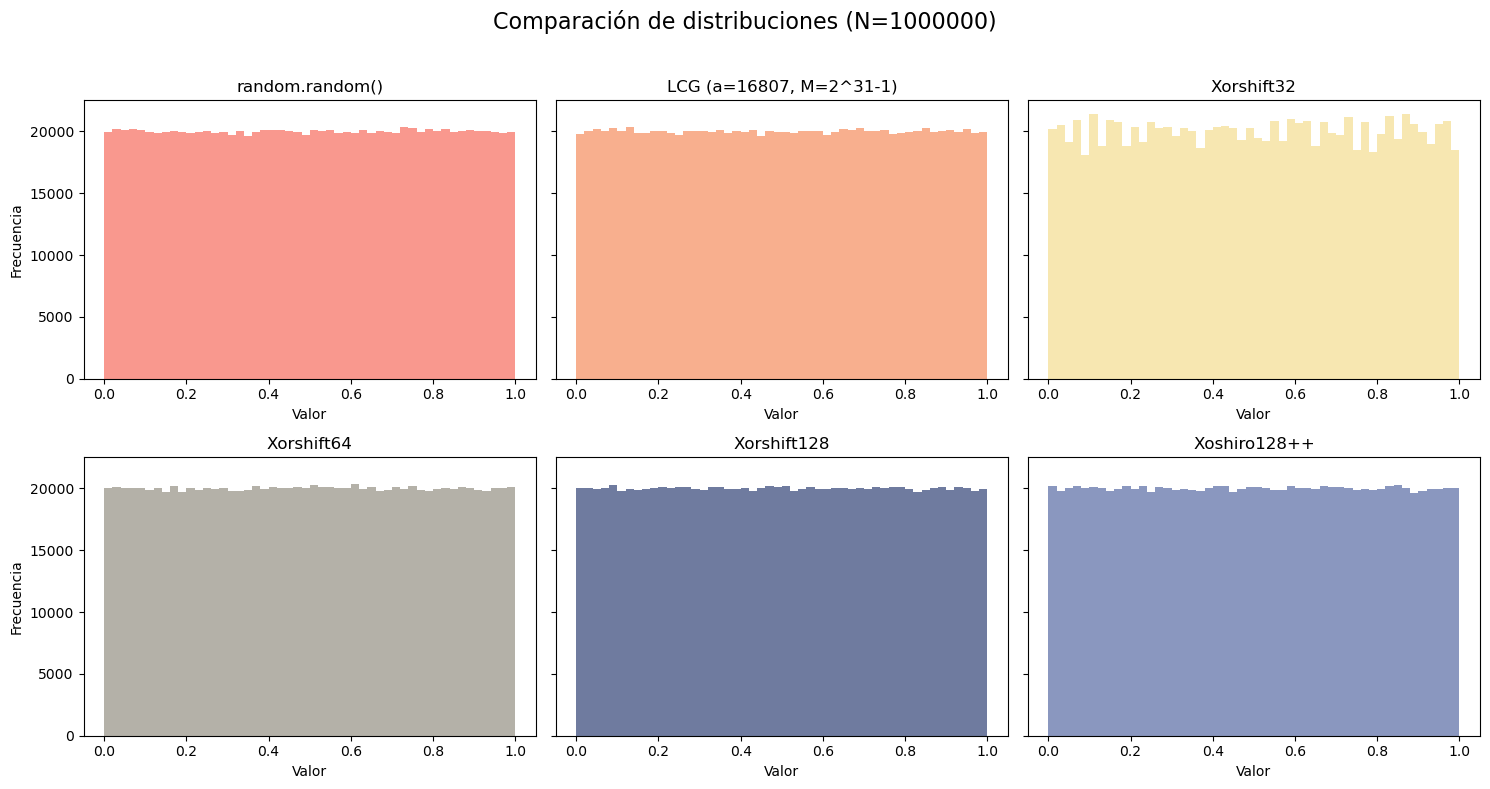

In [ ]:
import matplotlib.pyplot as plt
from random import random

# Generar muestras
N = 1_000_000
samples_random = [random() for _ in range(N)]
samples_lcg = [LCG() for _ in range(N)]
samples_xorshift32 = [Xorshift32() for _ in range(N)]
samples_xorshift64 = [Xorshift64() for _ in range(N)]
samples_xorshift128 = [Xorshift128() for _ in range(N)]
samples_xoshiro128 = [Xoshiro128() for _ in range(N)]

# Crear figura con 2 filas y 3 columnas
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
axes = axes.flatten()

# Histograma random()
axes[0].hist(samples_random, bins=50, color= '#F76C5E', alpha=0.7)
axes[0].set_title('random()')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Frecuencia')

# Histograma LCG
axes[1].hist(samples_lcg, bins=50, color='#F68E5F', alpha=0.7)
axes[1].set_title('LCG (a=16807, M=2^31-1)')
axes[1].set_xlabel('Valor')

# Histograma Xorshift32
axes[2].hist(samples_xorshift32, bins=50, color='#F5DD90', alpha=0.7)
axes[2].set_title('Xorshift32')
axes[2].set_xlabel('Valor')

# Histograma Xorshift64
axes[3].hist(samples_xorshift64, bins=50, color='#949083', alpha=0.7)
axes[3].set_title('Xorshift64')
axes[3].set_xlabel('Valor')
axes[3].set_ylabel('Frecuencia')

# Histograma Xorshift128
axes[4].hist(samples_xorshift128, bins=50, color='#324376', alpha=0.7)
axes[4].set_title('Xorshift128')
axes[4].set_xlabel('Valor')

# Histograma Xoshiro128++
axes[5].hist(samples_xoshiro128, bins=50, color='#586BA4', alpha=0.7)
axes[5].set_title('Xoshiro128++')
axes[5].set_xlabel('Valor')

# Ajustar diseño
plt.suptitle(f'Comparación de distribuciones (N={N})', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()




# SIMULACIONES

In [1049]:
from math import exp
from time import perf_counter as pc

def simular(rng, d ,N):
    """
    Dado un generador de numeros aleatorios (rng) normalizados en el intervalo [0,1), estima mediante
    el método de Monte Carlo para N simulaciones la integral definida sobre el hipercuobo [0, 1]^d.
    También devuelve el tiempo de ejecución como segunda coordenada.
    """
    inicio = pc()
    I = 0
    for _ in range(N):
        prod = 1
        for _ in range(d):
            X = rng()
            prod *= exp(-1 * X**2)
        I += prod
    final = pc()   

    return I/N, final-inicio

generadores = {
    "LCG": LCG,
    "Xorshift32": Xorshift32,
    "Xorshift64": Xorshift64,
    "Xorshift128": Xorshift128,
    "Xoshiro128": Xoshiro128
}

dimensiones = [2, 5, 10]
tamaños = [10**4, 10**5, 10**6]
valores_reales = {d: ((sqrtPi * erf1) / 2) ** d for d in dimensiones}

resultados = []

for nombre, rng in generadores.items():
    for d in dimensiones:
        valor_real = valores_reales[d]
        for N in tamaños:
            estimacion, tiempo = simular(rng, d, N)
            error_abs = abs(estimacion - valor_real)
            resultados.append((nombre, d, N, estimacion, tiempo, error_abs))
            print(f"{nombre:12} | d={d:<2} | N={N:<7} | Estimación={estimacion:.6f} | "
                  f"Error={error_abs:.2e} | Tiempo={tiempo:.2f}s")



LCG          | d=2  | N=10000   | Estimación=0.557266 | Error=4.81e-04 | Tiempo=0.02s
LCG          | d=2  | N=100000  | Estimación=0.558269 | Error=5.22e-04 | Tiempo=0.15s
LCG          | d=2  | N=1000000 | Estimación=0.557591 | Error=1.56e-04 | Tiempo=1.17s
LCG          | d=5  | N=10000   | Estimación=0.232811 | Error=4.88e-04 | Tiempo=0.03s
LCG          | d=5  | N=100000  | Estimación=0.231882 | Error=4.41e-04 | Tiempo=0.26s
LCG          | d=5  | N=1000000 | Estimación=0.232366 | Error=4.37e-05 | Tiempo=2.76s
LCG          | d=10 | N=10000   | Estimación=0.053419 | Error=5.55e-04 | Tiempo=0.05s
LCG          | d=10 | N=100000  | Estimación=0.053684 | Error=2.89e-04 | Tiempo=0.51s
LCG          | d=10 | N=1000000 | Estimación=0.054026 | Error=5.19e-05 | Tiempo=5.65s
Xorshift32   | d=2  | N=10000   | Estimación=0.557395 | Error=3.52e-04 | Tiempo=0.02s
Xorshift32   | d=2  | N=100000  | Estimación=0.557735 | Error=1.13e-05 | Tiempo=0.19s
Xorshift32   | d=2  | N=1000000 | Estimación=0.557625 